In [24]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/PINN

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/PINN


In [25]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.interpolate import griddata


torch.manual_seed(32)
np.random.seed(32)

E = 1                                       # Young's Modulus
nu = 0.3                                    # Poisson Ratio
G =  E/(2*(1+nu))                           # Shear modulus



In [26]:
# Define model parameters here
device = ("cuda" if torch.cuda.is_available() else "cpu")


# Load the collocation point data

points = scipy.io.loadmat('interior_points.mat')
boundary_points = scipy.io.loadmat('boundary_points.mat')

x = points['x']
y = points['y']

x_b = boundary_points['x_bdry']
y_b = boundary_points['y_bdry']

l = x.shape[0]
pts = np.column_stack((x,y))
b_pts = np.column_stack((x_b,y_b))

## Define data as PyTorch Tensor and send to device
xy_f_train = torch.tensor(pts, requires_grad=True, dtype=torch.float32).to(device)
xy_b_train = torch.tensor(b_pts, requires_grad=True, dtype=torch.float32).to(device)
 

# Define the boundary condition values
u_b_train = torch.zeros_like(xy_b_train[0,:])
v_b_train = torch.zeros_like(xy_b_train[1,:])

In [27]:

class Model(nn.Module):
    def __init__(self,E,nu,G):
        super(Model, self).__init__()
        self.Nnet = nn.Sequential()
        self.Nnet.add_module('Hidden_layer_1', nn.Linear(2,30))  # First linear layer
        self.Nnet.add_module('Tanh_layer_h_1', nn.Tanh())  # Add activation
        self.Nnet.add_module('Hidden_layer_2', nn.Linear(30,30))  # Second linear layer
        self.Nnet.add_module('Tanh_layer_h_2', nn.Tanh()) #Add activation
        self.Nnet.add_module('Hidden_layer_3', nn.Linear(30,30))  # Third linear layer
        self.Nnet.add_module('Tanh_layer_h_3', nn.Tanh()) #Add activation
        self.Nnet.add_module('Hidden_layer_4', nn.Linear(30,30))  # Fourth linear layer
        self.Nnet.add_module('Tanh_layer_h_4', nn.Tanh()) 
        self.Nnet.add_module('Hidden_layer_5', nn.Linear(30,30))  # Fiveth linear layer
        self.Nnet.add_module('Tanh_layer_h_5', nn.Tanh()) 
        self.Nnet.add_module('Output', nn.Linear(30,2))          # output
        print(self.Nnet)                                         # Print model summary
        self.E = E
        self.nu = nu
        self.G = G
        self.r = (1+nu)/(1-nu)
        self.lam1 = torch.tensor(0)

    # Forward Feed
    def forward(self, x):
        y = self.Nnet(x)
        return y

    def loads(self,x):
        uxx_f = -4*(torch.pi**2)*torch.sin(2*torch.pi*x[:,0])*torch.sin(2*torch.pi*x[:,1])
        uyy_f = -4*(torch.pi**2)*torch.sin(2*torch.pi*x[:,0])*torch.sin(2*torch.pi*x[:,1])
        uxy_f = 4*(torch.pi**2)*torch.cos(2*torch.pi*x[:,0])*torch.cos(2*torch.pi*x[:,1])

        vxx_f = -4*(torch.pi**2)*torch.sin(2*torch.pi*x[:,0])*torch.sin(torch.pi*x[:,1])
        vyy_f = -1*(torch.pi**2)*torch.sin(2*torch.pi*x[:,0])*torch.sin(torch.pi*x[:,1])
        vxy_f = 2*(torch.pi**2)*torch.cos(2*torch.pi*x[:,0])*torch.cos(torch.pi*x[:,1])

        f_1 = -self.G*(uxx_f + uyy_f + self.r*(uxx_f + vxy_f)) # Define body force for PDE-1
        f_2 =  -self.G*(vxx_f + vyy_f + self.r*(vyy_f + uxy_f))   # Define body force for PDE-2
        return f_1,f_2
        
    # PDE and BCs loss
    def loss(self,xy_f_train,xy_b_train):
        x, x_b = xy_f_train,xy_b_train
        sol = self.forward(x)
        sol_b = self.forward(x_b)
        y = sol                       # Interior Solution (output from defined NN model)
        y_b = sol_b                   # Boundary Solution (output from defined NN model)
        #u_b, v_b = u_b, v_b          # u and v boundary
        u,v = y[:,0],y[:,1]           # u and v interior

        # Calculate Gradients
        # Gradients of deformation in x-direction (first and second derivatives)
        u_g = self.gradients(u,x)[0]        # Gradient of u, Du = [u_x, u_y]
        u_x, u_y = u_g[:,0], u_g[:,1]         # [u_x, u_y]
        u_xx = self.gradients(u_x,x)[0][:,0]  # Second derivative, u_xx
        u_xy = self.gradients(u_x,x)[0][:,1]  # Mixed partial derivative, u_xy
        u_yy = self.gradients(u_y,x)[0][:,1]  # Second derivative, u_yy

        # Gradients of deformation in y-direction (first and second derivatives)
        v_g =  self.gradients(v,x)[0]        # Gradient of v, Dv = [v_x, v_y]
        v_x, v_y = v_g[:,0], v_g[:,1]            # [v_x, v_y]
        v_xx = self.gradients(v_x,x)[0][:,0]   # Second derivative, v_xx
        v_xy = self.gradients(v_x,x)[0][:,1]   # Mixed partial derivative, v_xy
        v_yy = self.gradients(v_y,x)[0][:,1]   # Second derivative, v_yy

        f_1,f_2 = self.loads(x)

        loss_1 =  self.G*(u_xx+u_yy) + self.G*((1+self.nu)/(1-self.nu)) *(u_xx+v_xy)+ f_1 # Define loss for PDE-1
        loss_2 =  self.G*(v_xx+v_yy) + self.G*((1+self.nu)/(1-self.nu)) *(v_yy+u_xy)+ f_2 # Define loss for PDE-2

        #lg1= self.gradients(loss_1,x)[0] 
        #lg2 = self.gradients(loss_2,x)[0]
        
        loss_PDE =   torch.mean((loss_1)**2) + torch.mean((loss_2)**2) # MSE PDE loss
        loss_bc =    torch.mean((y_b[:, 0])**2)+torch.mean((y_b[:, 1])**2) # MSE BCs loss
        residue_gradient = self.gradients(loss_PDE,model.parameters())[0]
        boundary_gradient = self.gradients(loss_bc,model.parameters())[0]
        # Compute the maximum gradient value
        max_gradient = torch.max(torch.abs(residue_gradient))

        # Compute the mean of the gradient magnitudes
        mean_gradient = torch.mean(torch.abs(boundary_gradient))
        lam = max_gradient / mean_gradient
        self.lam1 = 0.8*self.lam1 + 0.2*lam.item()
        #loss_g = torch.mean(lg1**2)  + torch.mean(lg2**2)
        TotalLoss = self.lam1*loss_bc + loss_PDE #+ 0.01*(loss_g)
        if epoch%100 == 0:
            print(f'epoch {epoch}: loss_pde {loss_PDE:.8f}, loss_bc {loss_bc:.8f}')
        return TotalLoss,loss_PDE,loss_bc

    def gradients(self, outputs, inputs):
        return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs),allow_unused=True, create_graph=True)


# Initialize model
model = Model(E,nu,G).to(device)

# Loss and Optimizer
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

Sequential(
  (Hidden_layer_1): Linear(in_features=2, out_features=30, bias=True)
  (Tanh_layer_h_1): Tanh()
  (Hidden_layer_2): Linear(in_features=30, out_features=30, bias=True)
  (Tanh_layer_h_2): Tanh()
  (Hidden_layer_3): Linear(in_features=30, out_features=30, bias=True)
  (Tanh_layer_h_3): Tanh()
  (Hidden_layer_4): Linear(in_features=30, out_features=30, bias=True)
  (Tanh_layer_h_4): Tanh()
  (Hidden_layer_5): Linear(in_features=30, out_features=30, bias=True)
  (Tanh_layer_h_5): Tanh()
  (Output): Linear(in_features=30, out_features=2, bias=True)
)


In [28]:
# Training
L_PDE = []
L_BC = []
L_total = []
def train(epoch):
    model.train()
    global L_BC
    global L_PDE
    global L_total
    def closure():
        optimizer.zero_grad()  # set gradients to 0
        TotalLoss,loss_PDE,loss_bc = model.loss(xy_f_train,xy_b_train)
        TotalLoss.backward(retain_graph=True)  # backpropagate for derivative of loss
        return TotalLoss,loss_PDE,loss_bc
    loss,loss_PDE,loss_bc = optimizer.step(closure)
    loss_t = loss.item()
    loss_b = loss_bc.item()
    loss_pde = loss_PDE.item()
    L_BC.append(loss_b)
    L_PDE.append(loss_pde)
    L_total.append(loss_t)
    if epoch%100 == 0:
        print(f'epoch {epoch}: loss {loss:.8f} ')
    return loss


In [29]:
for epoch in range(10000):
    train(epoch)

epoch 0: loss_pde 1282.87036133, loss_bc 0.09788378
epoch 0: loss 1284.84179688 
epoch 100: loss_pde 1282.43261719, loss_bc 0.00001265
epoch 100: loss 1283.00549316 
epoch 200: loss_pde 1278.75195312, loss_bc 0.00001679
epoch 200: loss 1282.38049316 
epoch 300: loss_pde 1253.68896484, loss_bc 0.00002779
epoch 300: loss 1259.94653320 
epoch 400: loss_pde 1184.92370605, loss_bc 0.00024598
epoch 400: loss 1207.62414551 
epoch 500: loss_pde 893.66381836, loss_bc 0.00817652
epoch 500: loss 961.55108643 
epoch 600: loss_pde 843.57720947, loss_bc 0.00755906
epoch 600: loss 907.58551025 
epoch 700: loss_pde 835.77502441, loss_bc 0.00496185
epoch 700: loss 891.39123535 
epoch 800: loss_pde 815.90246582, loss_bc 0.00539504
epoch 800: loss 874.90820312 
epoch 900: loss_pde 802.15246582, loss_bc 0.00523111
epoch 900: loss 847.97546387 
epoch 1000: loss_pde 790.62249756, loss_bc 0.00429768
epoch 1000: loss 851.69055176 
epoch 1100: loss_pde 797.46801758, loss_bc 0.00297186
epoch 1100: loss 867.6403

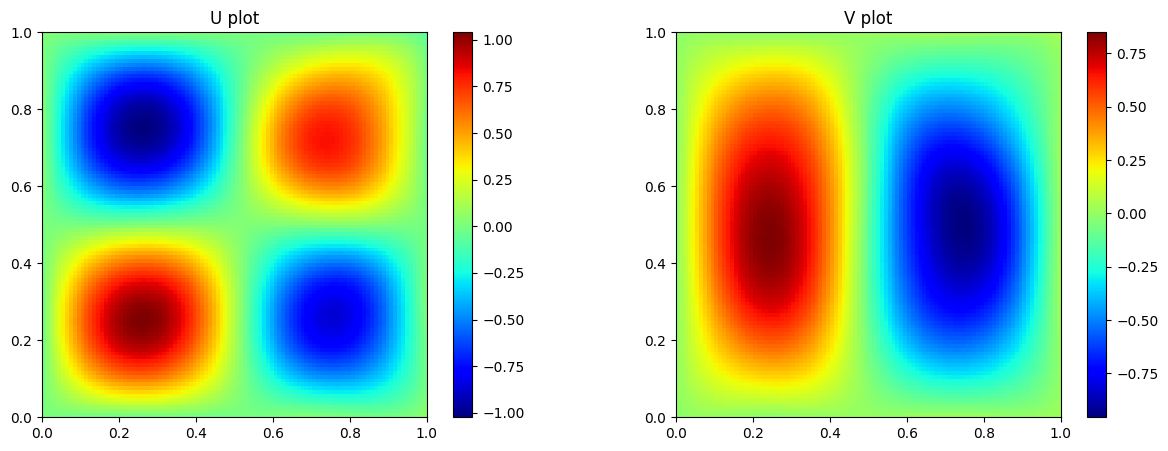

In [30]:
''' Plotting Training Field '''
# Plot the displacement field as contour
x_d = np.row_stack((x,x_b)).flatten()
y_d = np.row_stack((y,y_b)).flatten()
x_min, x_max = x_d.min(), x_d.max() 
y_min, y_max = y_d.min(), y_d.max()
x_line = np.linspace(x_min,x_max,100)
y_line = np.linspace(y_min,y_max,100)
x_m, y_m = np.meshgrid(x_line,y_line)
 
sol = model.forward(xy_f_train)
sol_b = model.forward(xy_b_train)
sol_tot = torch.cat((sol,sol_b),dim=0).cpu().detach().numpy()
u = sol_tot[:,0] 
v = sol_tot[:,1] 

u_i = griddata((x_d, y_d),u,(x_m,y_m), method='linear') # Interpolate 
v_i = griddata((x_d, y_d),v,(x_m,y_m), method='linear') # Interpolate 

# Plot results
plt.subplots(1, 2, figsize=(15, 5))
plt.subplot(1,2,1)
plt.imshow(u_i, cmap='jet',origin='lower',extent=[x_min, x_max, y_min, y_max])
plt.title("U plot")
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(v_i, cmap='jet',origin='lower',extent=[x_min, x_max, y_min, y_max])
plt.title("V plot")
plt.colorbar()
plt.show()

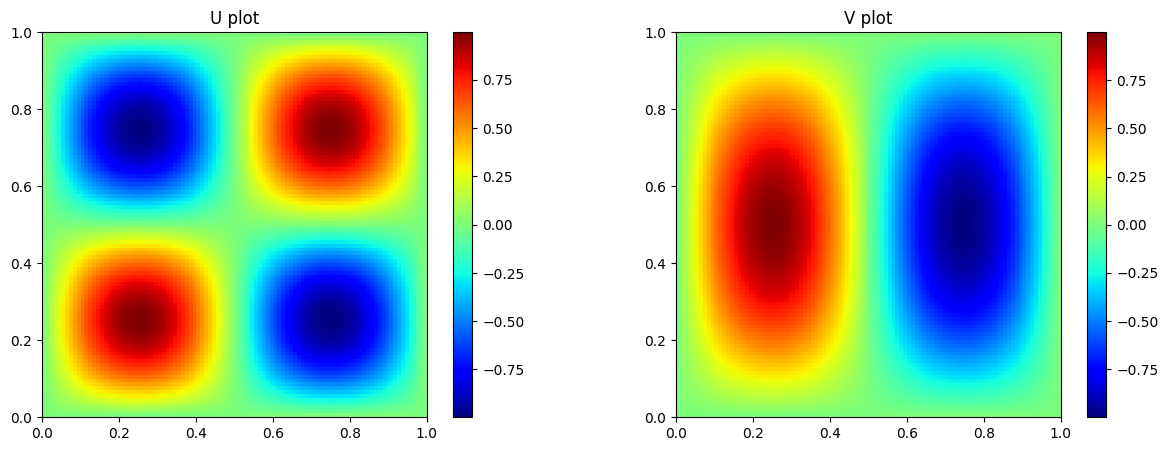

In [31]:
x_tot = torch.cat((xy_f_train,xy_b_train),dim=0).cpu().detach().numpy()
u_exact = np.sin(2*np.pi*x_tot[:,0])*np.sin(2*np.pi*x_tot[:,1])
v_exact = np.sin(2*np.pi*x_tot[:,0])*np.sin(np.pi*x_tot[:,1])

u_i = griddata((x_d, y_d),u_exact,(x_m,y_m), method='linear') # Interpolate 
v_i = griddata((x_d, y_d),v_exact,(x_m,y_m), method='linear') # Interpolate 

# Plot results
plt.subplots(1, 2, figsize=(15, 5))
plt.subplot(1,2,1)
plt.imshow(u_i, cmap='jet',origin='lower',extent=[x_min, x_max, y_min, y_max])
plt.title("U plot")
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(v_i, cmap='jet',origin='lower',extent=[x_min, x_max, y_min, y_max])
plt.title("V plot")
plt.colorbar()
plt.show()

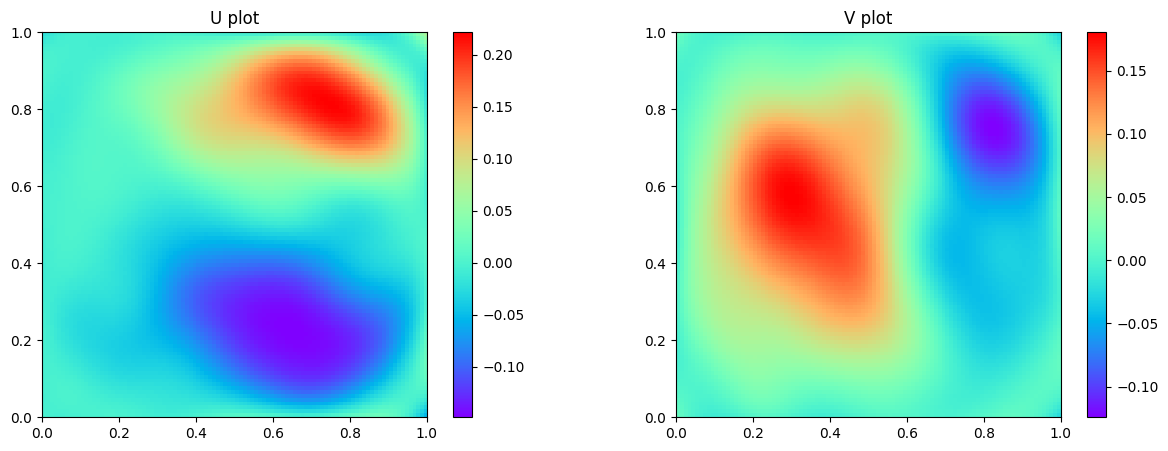

In [32]:
u_error = u_exact -u
v_error = v_exact - v

u_i = griddata((x_d, y_d),u_error,(x_m,y_m), method='linear') # Interpolate 
v_i = griddata((x_d, y_d),v_error,(x_m,y_m), method='linear') # Interpolate 

# Plot results
plt.subplots(1, 2, figsize=(15, 5))
plt.subplot(1,2,1)
plt.imshow(u_i, cmap='rainbow',origin='lower',extent=[x_min, x_max, y_min, y_max])
plt.title("U plot")
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(v_i, cmap='rainbow',origin='lower',extent=[x_min, x_max, y_min, y_max])
plt.title("V plot")
plt.colorbar()
plt.show()

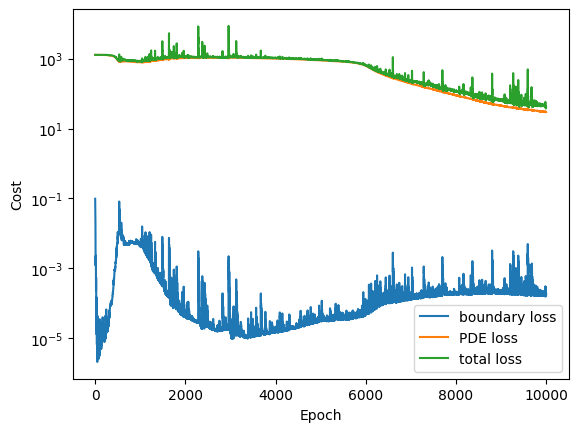

In [33]:
'''Ploting Cost History'''
plt.figure()
plt.plot(L_BC,label = 'boundary loss')
plt.yscale('log')
plt.plot(L_PDE,label = 'PDE loss')
plt.plot(L_total,label = 'total loss')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.legend()
plt.show()

In [34]:
u_mse = np.mean(u_error**2)
v_mse = np.mean(v_error**2)
u_mse,v_mse

(0.00557421, 0.0051755197)

In [35]:
L_BC = np.array(L_BC)
L_PDE = np.array(L_PDE)
L_total = np.array(L_total)
# Save the NumPy array to a file
np.save('L_BC_ag.npy', L_BC)
np.save('L_PDE_ag.npy', L_PDE)
np.save('L_total_ag.npy', L_total)

In [36]:
torch.save(model.state_dict(), 'agPINN.pt')